In [1]:
import sys
sys.path.append(r'../')
from ioMicro import *

In [42]:
fl =r'W:\RoyGoldman_11_08_2023\H1_SLC1A2_SOX2_PTGFR\Conv_zscan__120.zarr'
im = read_im(fl)
import napari
napari.view_image(im[0]);

In [11]:
im_ = np.array(im[0],dtype=np.float32)

In [13]:
im_n = norm_slice(im_,s=30)

In [24]:
Xh = get_local_maxfast_tensor(im_n,im_raw=im_,th_fit=300,gpu=True,delta=5,delta_fit=5)
Xh = Xh[Xh[:,-2]>0.5]

In [25]:
V = napari.view_image(im_n);
V.add_points(Xh[:,:3],size=8,face_color=[0,0,0,0],edge_color='y')

<Points layer 'Points' at 0x2cf7b5cb490>

In [32]:
xymax=3000
bin = 300
dic_slices = {(0,i,j):tuple([slice(None),slice(i,i+bin),slice(j,j+bin)]) for i in range(0,xymax,bin) for j in range(0,xymax,bin)}

In [29]:
slice_ = slices[len(slices)//2]#slices[-1]
psf = get_psf(im_[slice_],th=300,th_cor = 0.5,delta=5,delta_fit = 5,sxyzP = [15,60,60])

In [30]:
napari.view_image(psf)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 60.0, 60.0), zoom=9.86900826446281, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(15.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 31.0, 1.0), (0.0, 121.0, 1.0), (0.0, 121.0, 1.0)), current_step=(15, 60, 60), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'psf' at 0x2cf807bd580>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ], dtype=float32), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 't

### Compute psf

In [34]:
dic_psfs = {}
for key in dic_slices:
    dic_psfs[key]=[]

In [43]:
master_folder = r'W:\RoyGoldman_11_08_2023\H1_SLC1A2_SOX2_PTGFR'

for ifov in tqdm(np.arange(120,150)):
    im = read_im(master_folder+r'\Conv_zscan__'+str(ifov).zfill(3)+'.zarr')
    im_ = np.array(im[0],dtype=np.float32)
    slices = list(dic_slices.keys())
    for key in tqdm(slices):
        slice_ = dic_slices[key]
        psf = get_psf(im_[slice_],th=300,th_cor = 0.5,delta=5,delta_fit = 5,sxyzP = [15,60,60])
        dic_psfs[key].append(psf)
#napari.view_image(im)


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [2:15:58<00:00, 271.94s/it]


In [44]:
pickle.dump(dic_psfs,open('dic_psf_scope2_40X_750_300pix.pkl','wb'))

In [61]:
psfs = np.array(dic_psfs[(0, 2700, 2700)])
napari.view_image(np.mean(psfs,axis=0))

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 60.0, 60.0), zoom=4.357438016528925, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(15.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 31.0, 1.0), (0.0, 121.0, 1.0), (0.0, 121.0, 1.0)), current_step=(15, 60, 60), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x2ce5e03ee80>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ], dtype=float32), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT:

In [63]:
def clean_psf(psfs):
    psff = np.mean([psf for psf in psfs if psf is not None],axis=0)
    psff_ = np.array([p-np.median(p) for p in psff])
    from scipy.ndimage import median_filter
    psff_med = median_filter(psff_, size=15)
    psfff = (psff_-psff_med)[5:-5,5:-5,5:-5][:-1,:-1,:-1]
    psfff[psfff<0]=0
    psfff = psfff/np.max(psfff)
    return psfff

In [66]:
dic_psfff = {key:clean_psf(dic_psfs[key]) for key in tqdm(list(dic_psfs.keys()))}
pickle.dump(dic_psfff,open('dic_psfff_scope2_40X_750_300pix.pkl','wb'))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [20:10<00:00, 12.11s/it]


In [68]:
type(dic_psfff) is dict

True

In [97]:
im = read_im(r'W:\RoyGoldman_11_08_2023\H10_MER\Conv_zscan__177.zarr')
im_ = np.array(im[0],dtype=np.float32)

In [90]:
imD2 = full_deconv(im_,s_=300,pad=100,psf=dic_psfff,parameters={'method': 'wiener', 'beta': 0.0001, 'niter': 50},gpu=True,force=True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.04it/s]


In [7]:
im = read_im(r'W:\RoyGoldman_11_08_2023\H10_MER\Conv_zscan__150.zarr')
icol = 2
im_ = np.array(im[icol],dtype=np.float32)
flat_field_tag = r'C:\Scripts\NMERFISH\flat_field\Scope2_40X_'
fl_med = flat_field_tag+'med_col_raw'+str(icol)+'.npz'
if os.path.exists(fl_med):
    im_med = np.array(np.load(fl_med)['im'],dtype=np.float32)
    im_med = cv2.blur(im_med,(20,20))
    im__ = im_/im_med*np.median(im_med)

In [3]:
psf_file = 'dic_psfff_scope2_40X_750_300pix.pkl'
psf = np.load(psf_file,allow_pickle=True)

In [8]:
Xh = get_local_max_tile(im__,th=3600,s_ = 300,pad=100,psf=psf,plt_val=None,snorm=30,gpu=True,
                                    deconv={'method':'wiener','beta':0.0001},
                                    delta=1,delta_fit=3,sigmaZ=1,sigmaXY=1.5)

(749285, 8)

In [12]:
import napari
V = napari.view_image(im__)
V.add_points(Xh[:,:3],size=10,edge_color='y',face_color=[0,0,0,0])


<Points layer 'Points' at 0x1c5ce4c7910>

In [99]:
V = napari.view_image(im_)
V.add_image(im__)

<Image layer 'im__' at 0x2d095e94970>

In [89]:
V = napari.view_image(imD2)
im_n = norm_slice(im_,s=30)
V.add_image(imD)
V.add_image(im_n)

<Image layer 'im_n' at 0x2d090d3e0a0>

In [69]:
def full_deconv(im_,s_=500,pad=100,psf=None,parameters={'method': 'wiener', 'beta': 0.001, 'niter': 50},gpu=True,force=False):
    im0=np.zeros_like(im_)
    sx,sy = im_.shape[1:]
    ixys = []
    for ix in np.arange(0,sx,s_):
        for iy in np.arange(0,sy,s_):
            ixys.append([ix,iy])
    
    for ix,iy in tqdm(ixys):#ixys:#tqdm(ixys):
        imsm = im_[:,ix:ix+pad+s_,iy:iy+pad+s_]
        if type(psf) is dict:
            keys = list(psf.keys())
            ikey = np.argmin(np.sum(np.abs(np.array(keys)-[0,ix,iy]),axis=-1))
            psf_ = psf[keys[ikey]]
            force=True
        else:
            psf_ = psf
        imt = apply_deconv(imsm,psf=psf_,parameters=parameters,gpu=gpu,plt_val=False,force=force)
        start_x = ix+pad//2 if ix>0 else 0
        end_x = ix+pad//2+s_
        start_y = iy+pad//2 if iy>0 else 0
        end_y = iy+pad//2+s_
        #print(start_x,end_x,start_y,end_y)
        im0[:,start_x:end_x,start_y:end_y] = imt[:,(start_x-ix):(end_x-ix),(start_y-iy):(end_y-iy)]
    return im0

In [16]:
if False:
    imd = apply_deconv(im_[:,750:-750,750:-750],
        psf=psf,
        plt_val=True,
        parameters={'method': 'wiener', 'beta': 0.0001, 'niter': 50},
        gpu=False,
        force=True,
        pad=None)

In [22]:
import shutil
save_folder = os.path.dirname(master_folder)+os.sep+'MERFISH_Analysis'
if not os.path.exists(save_folder): os.makedirs(save_folder)
shutil.copy2(os.path.abspath('psf_750_Scope3_final.npy'),save_folder+os.sep+'psf_750_Scope3_final.npy')

'\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\MERFISH_Analysis\\psf_750_Scope3_final.npy'

### Compute flat field

In [24]:
#np.load(r'\\192.168.0.100\bbfish100\DCBBL1_1year1wkNJ_ASO_SAL_4_18_2023\MERFISH_Analysis\med_col0.npz')['im'].shape

(300, 300)

In [2]:
data_fld = r'\\192.168.0.100\bbfish100\DCBBL1_4week_6_2_2023\P2_Sox11_Sox2_Dcx__set1'
save_folder = os.path.dirname(data_fld)+os.sep+'MERFISH_Analysis'
if not os.path.exists(save_folder): os.makedirs(save_folder)

In [3]:
compute_flat_field_raw(data_fld=data_fld,
    save_folder=save_folder,
    ncols=4)

100%|████████████████████████████████████████████████████████████████████████████████| 698/698 [06:43<00:00,  1.73it/s]


### Compute mosaics

In [1]:
import time
import numpy as np,os,sys,glob
import matplotlib.pylab as plt
from ioMicro import *

data_flds = glob.glob(r'\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\H0__*')
for data_fld in data_flds:
    resc = 4
    icol = -1
    save_folder= os.path.dirname(data_fld)+os.sep+'mosaics'
    if not os.path.exists(save_folder): os.makedirs(save_folder)
    if os.path.isdir(data_fld):
        
        fl_save = save_folder+os.sep+os.path.basename(data_fld)+'_col'+str(icol)+'.png'
        print(fl_save)
        if not os.path.exists(fl_save):
            fls_ = np.sort(glob.glob(data_fld+r'\*.zarr'))
            ims,xs_um,ys_um=[],[],[]
            from tqdm.notebook import tqdm

            for fl in tqdm(fls_[:]):
                im,x,y = read_im(fl,return_pos=True)
                ims.append(np.array(im[icol][15,::resc,::resc],dtype=np.float32))
                xs_um.append(x)
                ys_um.append(y)

            im_big,xs,ys = compose_mosaic([im.T[::-1,::1] for im in ims],xs_um,ys_um,ims_c=None,
                                          um_per_pix=0.1083333*resc,
                                          rot = 0,return_coords= True)


            resc_ = 3
            data_fld = os.path.dirname(fls_[0])
            fig = plt.figure(figsize=(30,30))
            im__ = im_big[::resc_,::resc_]
            vmax = np.percentile(im__[im__>0],99.)
            plt.imshow(im_big.T[::resc_,::resc_],vmin=0,vmax=vmax,cmap='gray')


            fig.savefig(fl_save)
            for x_,y_,fl_ in zip(xs,ys,fls_):
                ifov = fl_.split('_')[-1].split('.')[0]
                plt.text(x_/resc_,y_/resc_,ifov,color='r')
            plt.xticks([])
            plt.yticks([])
            fl_save = fl_save.replace('.png','_annot.png')
            print(fl_save)
            fig.savefig(fl_save)
            plt.close('all')
#     else:
#         time.sleep(300)

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set1_col-1.png


  0%|          | 0/67 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set1_col-1_annot.png
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set2_col-1.png


  0%|          | 0/27 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set2_col-1_annot.png
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set3_col-1.png


  0%|          | 0/74 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set3_col-1_annot.png
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set4_col-1.png


  0%|          | 0/58 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set4_col-1_annot.png
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set5_col-1.png


  0%|          | 0/91 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set5_col-1_annot.png


### Compute one fov

In [1]:
from ioMicro import *
from workerScope3New import *
#get_files(['_set1',30])

main_f(['_set1',30],redo_fits = False,redo_drift=False,redo_decoding=False,try_mode=False)

Computing fitting on: Conv_zscan__030.zarr
19 ['\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H0__set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\P1__Igfbp_Aldh1l1_Ptbp1__set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H1_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\P2_Sox11_Sox2_Dcx__set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H2_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H3_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H4_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H5_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H6_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H7_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H8_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H9_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H10_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4we

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [48:05<00:00, 151.87s/it]


Computing drift on: Conv_zscan__030.zarr
Computing drift...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [04:25<00:00, 13.96s/it]


Not completed


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:34<00:00, 111.34s/it]


Unfolded molecules: 132.8494153022766
Computed the decoding: 160.5524594783783


100%|███████████████████████████████████████████████████████████████████| 16172708/16172708 [02:51<00:00, 94427.83it/s]


Computed best unique assigment: 174.56177759170532


['_set1', 30]

In [6]:
from ioMicro import *

save_folder = r'\\192.168.0.100\bbfish100\DCBBL1_4week_6_2_2023\MERFISH_Analysis'
fov,set_ = 'Conv_zscan__030','_set1'
dec = decoder_simple(save_folder,fov,set_)
dec.load_decoded()

Loaded decoded: -4.9082701206207275


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  5.22it/s]


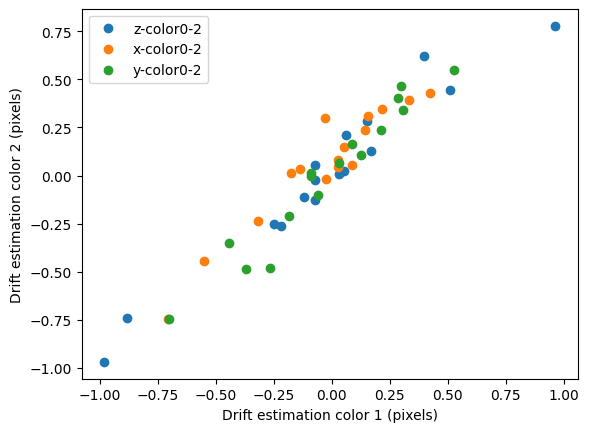

In [9]:
apply_fine_drift(dec,plt_val=True)

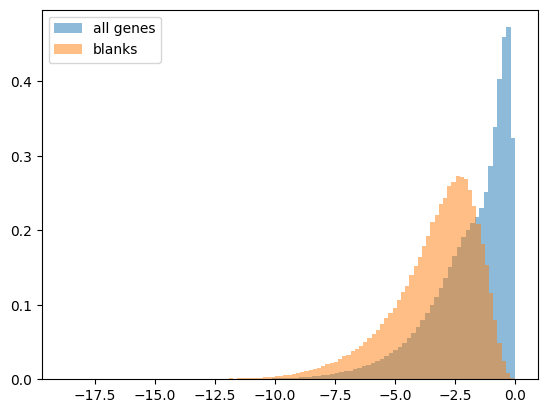

In [11]:
dec.ncols=3
scoresRef = get_score_per_color(dec)
get_score_withRef(dec,scoresRef,plt_val=True,gene=None,iSs = None)
dec.th=-1.5
plot_statistics(dec)

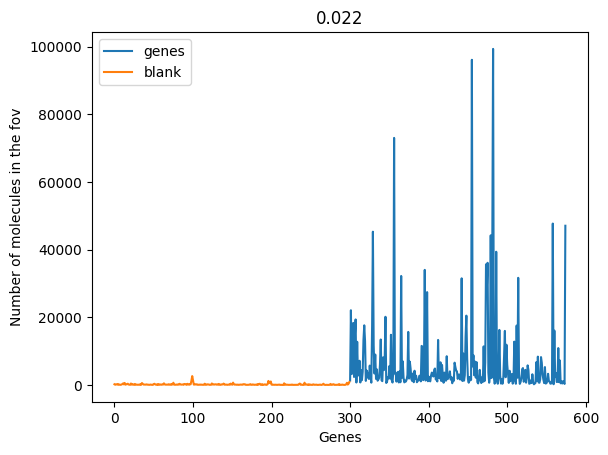

In [12]:
dec.th=-1.5
plot_statistics(dec)

In [31]:
viewer = plot_multigenes(dec,genes=['Vim'],colors=['r','g','b','m','c','y','w'],viewer = None,
                         smin=2,smax=10)

In [18]:
dec.gns_names[250:]

array(['blank0251', 'blank0252', 'blank0253', 'blank0254', 'blank0255',
       'blank0256', 'blank0257', 'blank0258', 'blank0259', 'blank0260',
       'blank0261', 'blank0262', 'blank0263', 'blank0264', 'blank0265',
       'blank0266', 'blank0267', 'blank0268', 'blank0269', 'blank0270',
       'blank0271', 'blank0272', 'blank0273', 'blank0274', 'blank0275',
       'blank0276', 'blank0277', 'blank0278', 'blank0279', 'blank0280',
       'blank0281', 'blank0282', 'blank0283', 'blank0284', 'blank0285',
       'blank0286', 'blank0287', 'blank0288', 'blank0289', 'blank0290',
       'blank0291', 'blank0292', 'blank0293', 'blank0294', 'blank0295',
       'blank0296', 'blank0297', 'blank0298', 'blank0299', 'blank0300',
       'Acer3', 'Actg1', 'Adcy2', 'Ahcyl2', 'Aldoc', 'Ascl1', 'Auts2',
       'Bhlhe22', 'Bmp2', 'Bsg', 'C1qa', 'Calb1', 'Cck', 'Cdh12', 'Cdk4',
       'Chrdl1', 'Cnr1', 'Csmd1', 'Cst3', 'Dgat2', 'Dlx1', 'Dsp',
       'Eif4a2', 'Emx2', 'Eomes', 'Fam107a', 'Flt1', 'Foxa2', 'Foxg1'

### Check progress

In [3]:
#save_folder =r'\\192.168.0.6\bbfishjoy4\CGBB_embryo_4_28_2023\MERFISH_Analysis3'
import os,glob,numpy as np
data_fld = r'\\192.168.0.100\bbfish100\DCBBL1_4week_6_2_2023\P2_Sox11_Sox2_Dcx__set1'
save_folder = os.path.dirname(data_fld)+os.sep+'MERFISH_Analysis'
fls = glob.glob(save_folder+os.sep+'decoded*')

In [4]:
len(fls)

504

In [7]:
fov_fls = glob.glob(save_folder+os.sep+'*fov*')
fov_all = [(fl_,os.path.basename(fl).split('__')[-1].split('.')[0]) for fl in fov_fls for fl_ in np.load(fl)]

print(len(fov_all))

fov_completed = [tuple(os.path.basename(fl).replace('decoded_','').replace('.npz','').replace('--','.zarr--').split('--'))for fl in fls]
#[e for e in fov_all if e not in fov_completed]

813


In [15]:
times = [os.path.getctime(fl) for fl in fls]
diffT = np.diff(np.sort(times)).astype(int)
np.median(diffT),np.mean(diffT[-50:])

(483.5, 881.32)

829.08

In [10]:
diffT

array([25353,   533,   146,     4,    93,  1036,  3370,   456,     0,
         166,   223,  1089,  3286,    79,   365,   219,   129,  3295,
         271,   585,   276,   295,  2234,   928,   841,   187,   490,
         952,  1112,  1780,   144,   668,   353,   902,  2561,   131,
         630,   123,   922,  2110,    13,  1430,   104,   139,  2419,
         111,  2044,    26,   339,   696,   280,  3123,   230,    83,
         122,   731,  1762])